In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [4]:
adata = anndata.read_h5ad("../bct_raw.h5ad")
adata
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 9288 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type'
    var: 'gene.symbols', 'gene.counts'

In [5]:
unique_batches = adata.obs['batch'].unique()
unique_batches

['vis', 'spk', 'wal']
Categories (3, object): ['spk', 'vis', 'wal']

### Setting: Only batch = spk doesn't have annotations

In [7]:
import numpy as np

# Initialize all labels with the corresponding 'cell_type'
adata.obs['batch_labels'] = adata.obs['cell_type']

# Ensure "Unknown" is a category before assigning it
adata.obs['batch_labels'] = adata.obs['batch_labels'].cat.add_categories("Unknown")

# Set the specified batch (e.g., target_batch) to "Unknown"
target_batch = "spk"
adata.obs.loc[adata.obs['batch'] == target_batch, 'batch_labels'] = "Unknown"

# Convert the 'batch_labels' column to category type (if not already)
adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

In [8]:
# Save the new_labels column to a CSV file
adata.obs.to_csv('../R_bct/labels/partially_annotated_batches_bct_1.csv', index=True)

In [9]:
adata.obs['batch_labels'] = pd.read_csv('../R_bct/labels/partially_annotated_batches_bct_1.csv')['batch_labels'].values

In [10]:
adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

In [10]:
adata.obs['batch_labels']

vis1           luminal_mature
vis2                    basal
vis3       luminal_progenitor
vis4           luminal_mature
vis5           luminal_mature
                  ...        
wal4370        luminal_mature
wal4371    luminal_progenitor
wal4372        luminal_mature
wal4374        luminal_mature
wal4375    luminal_progenitor
Name: batch_labels, Length: 9288, dtype: object

In [11]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [12]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [17]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/385:   0%| | 1/385 [00:01<11:58,  1.87s/it, v_num=1, train_loss_step=569

In [13]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [14]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

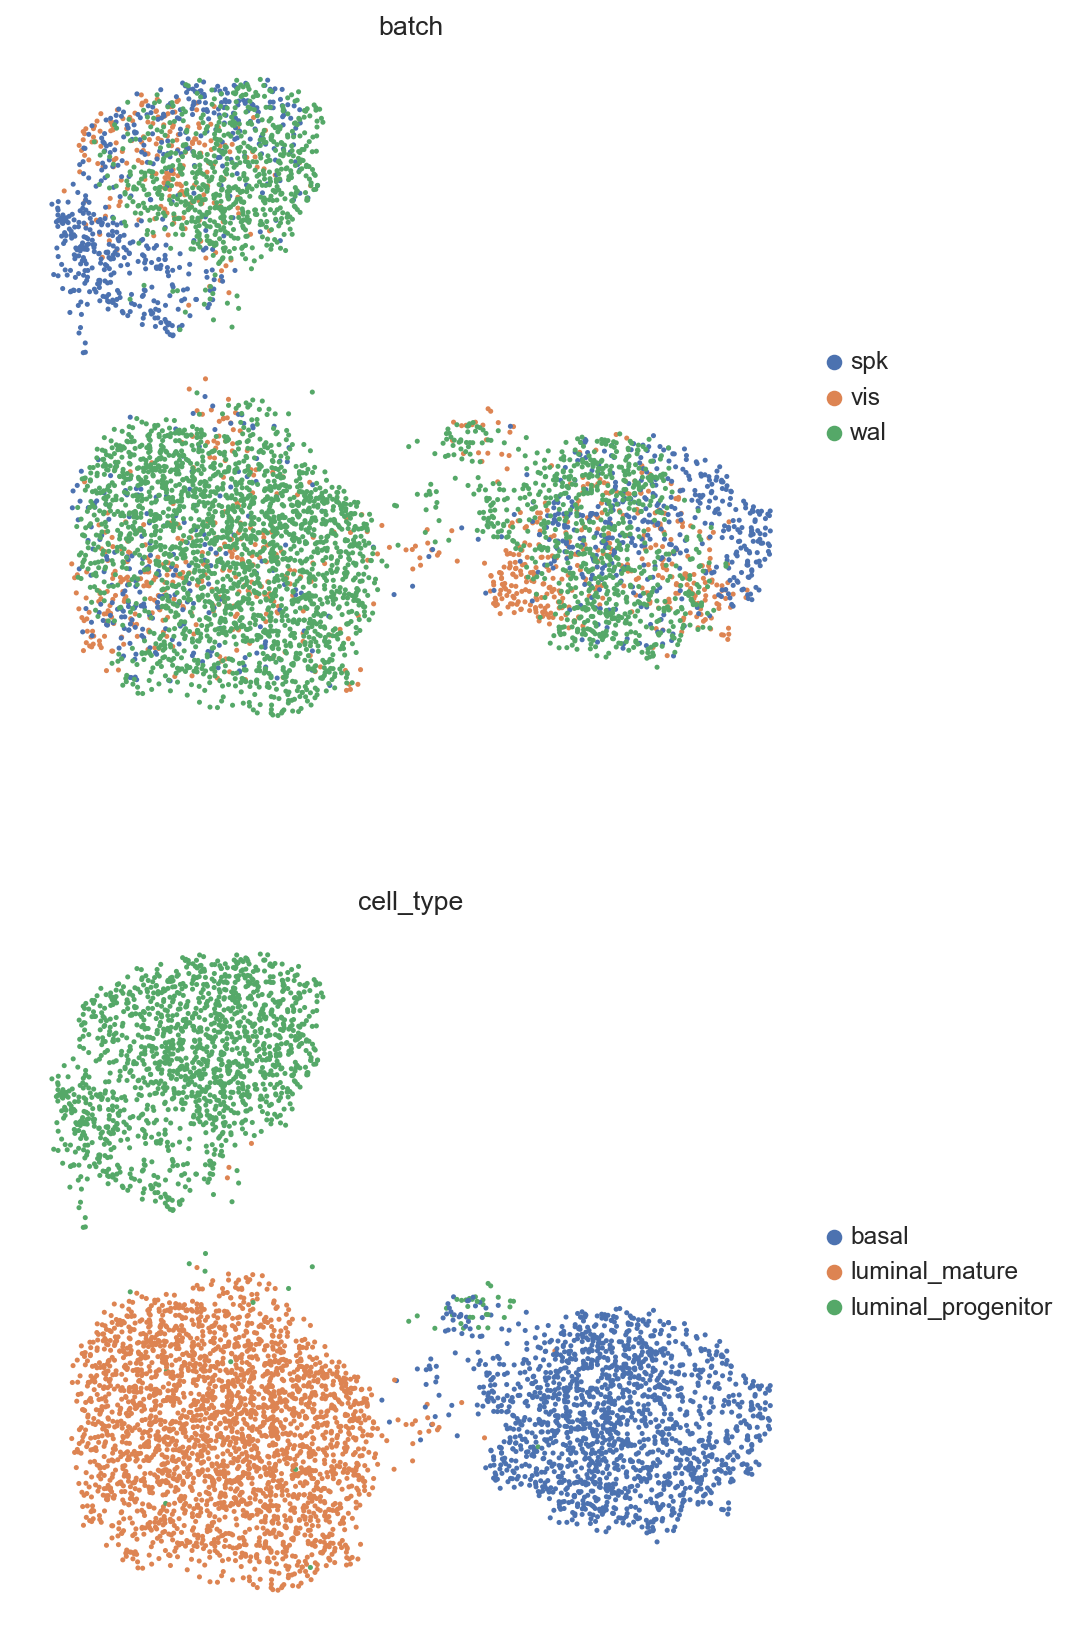

In [15]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [16]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="batch_labels",
    unlabeled_category="Unknown",
)

In [17]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [00:37<00:00,  1.82s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.26e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.26e+3]


In [18]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [19]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [20]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

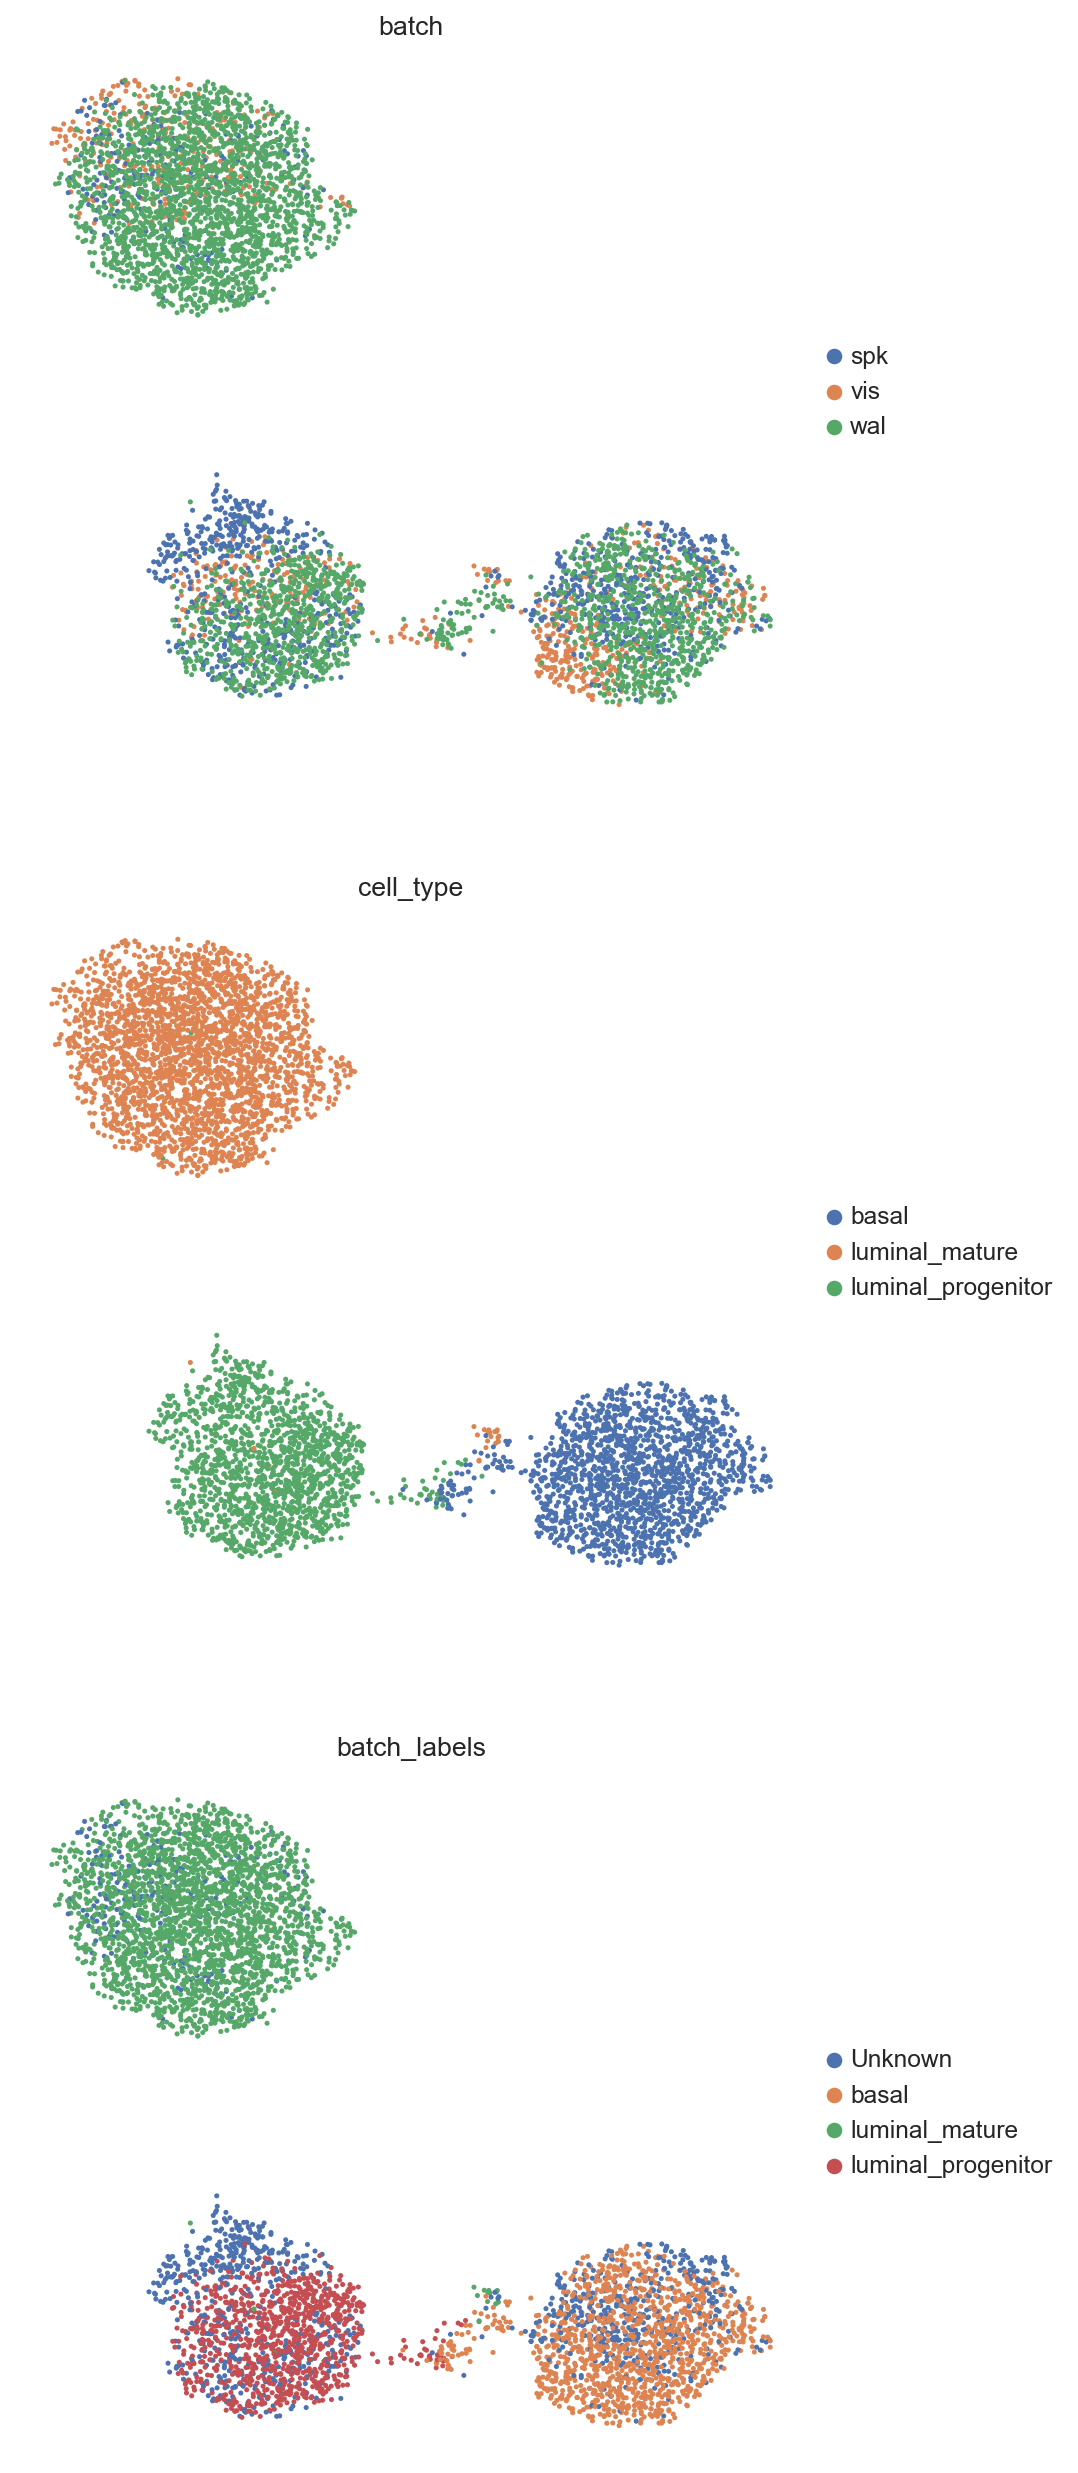

In [22]:
sc.pl.umap(adata, color=["batch", "cell_type", "batch_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata

In [23]:
train = adata.copy()

### Preprocessing Data

In [24]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="batch_labels")

## Creating and Training the model¶

In [25]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 30/100:  30%|███       | 30/100 [02:34<05:59,  5.14s/it, v_num=1, train_loss_step=435, train_loss_epoch=465]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1668.410. Signaling Trainer to stop.


## Batch-Removal

In [26]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 5747 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type', 'batch_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [27]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [28]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

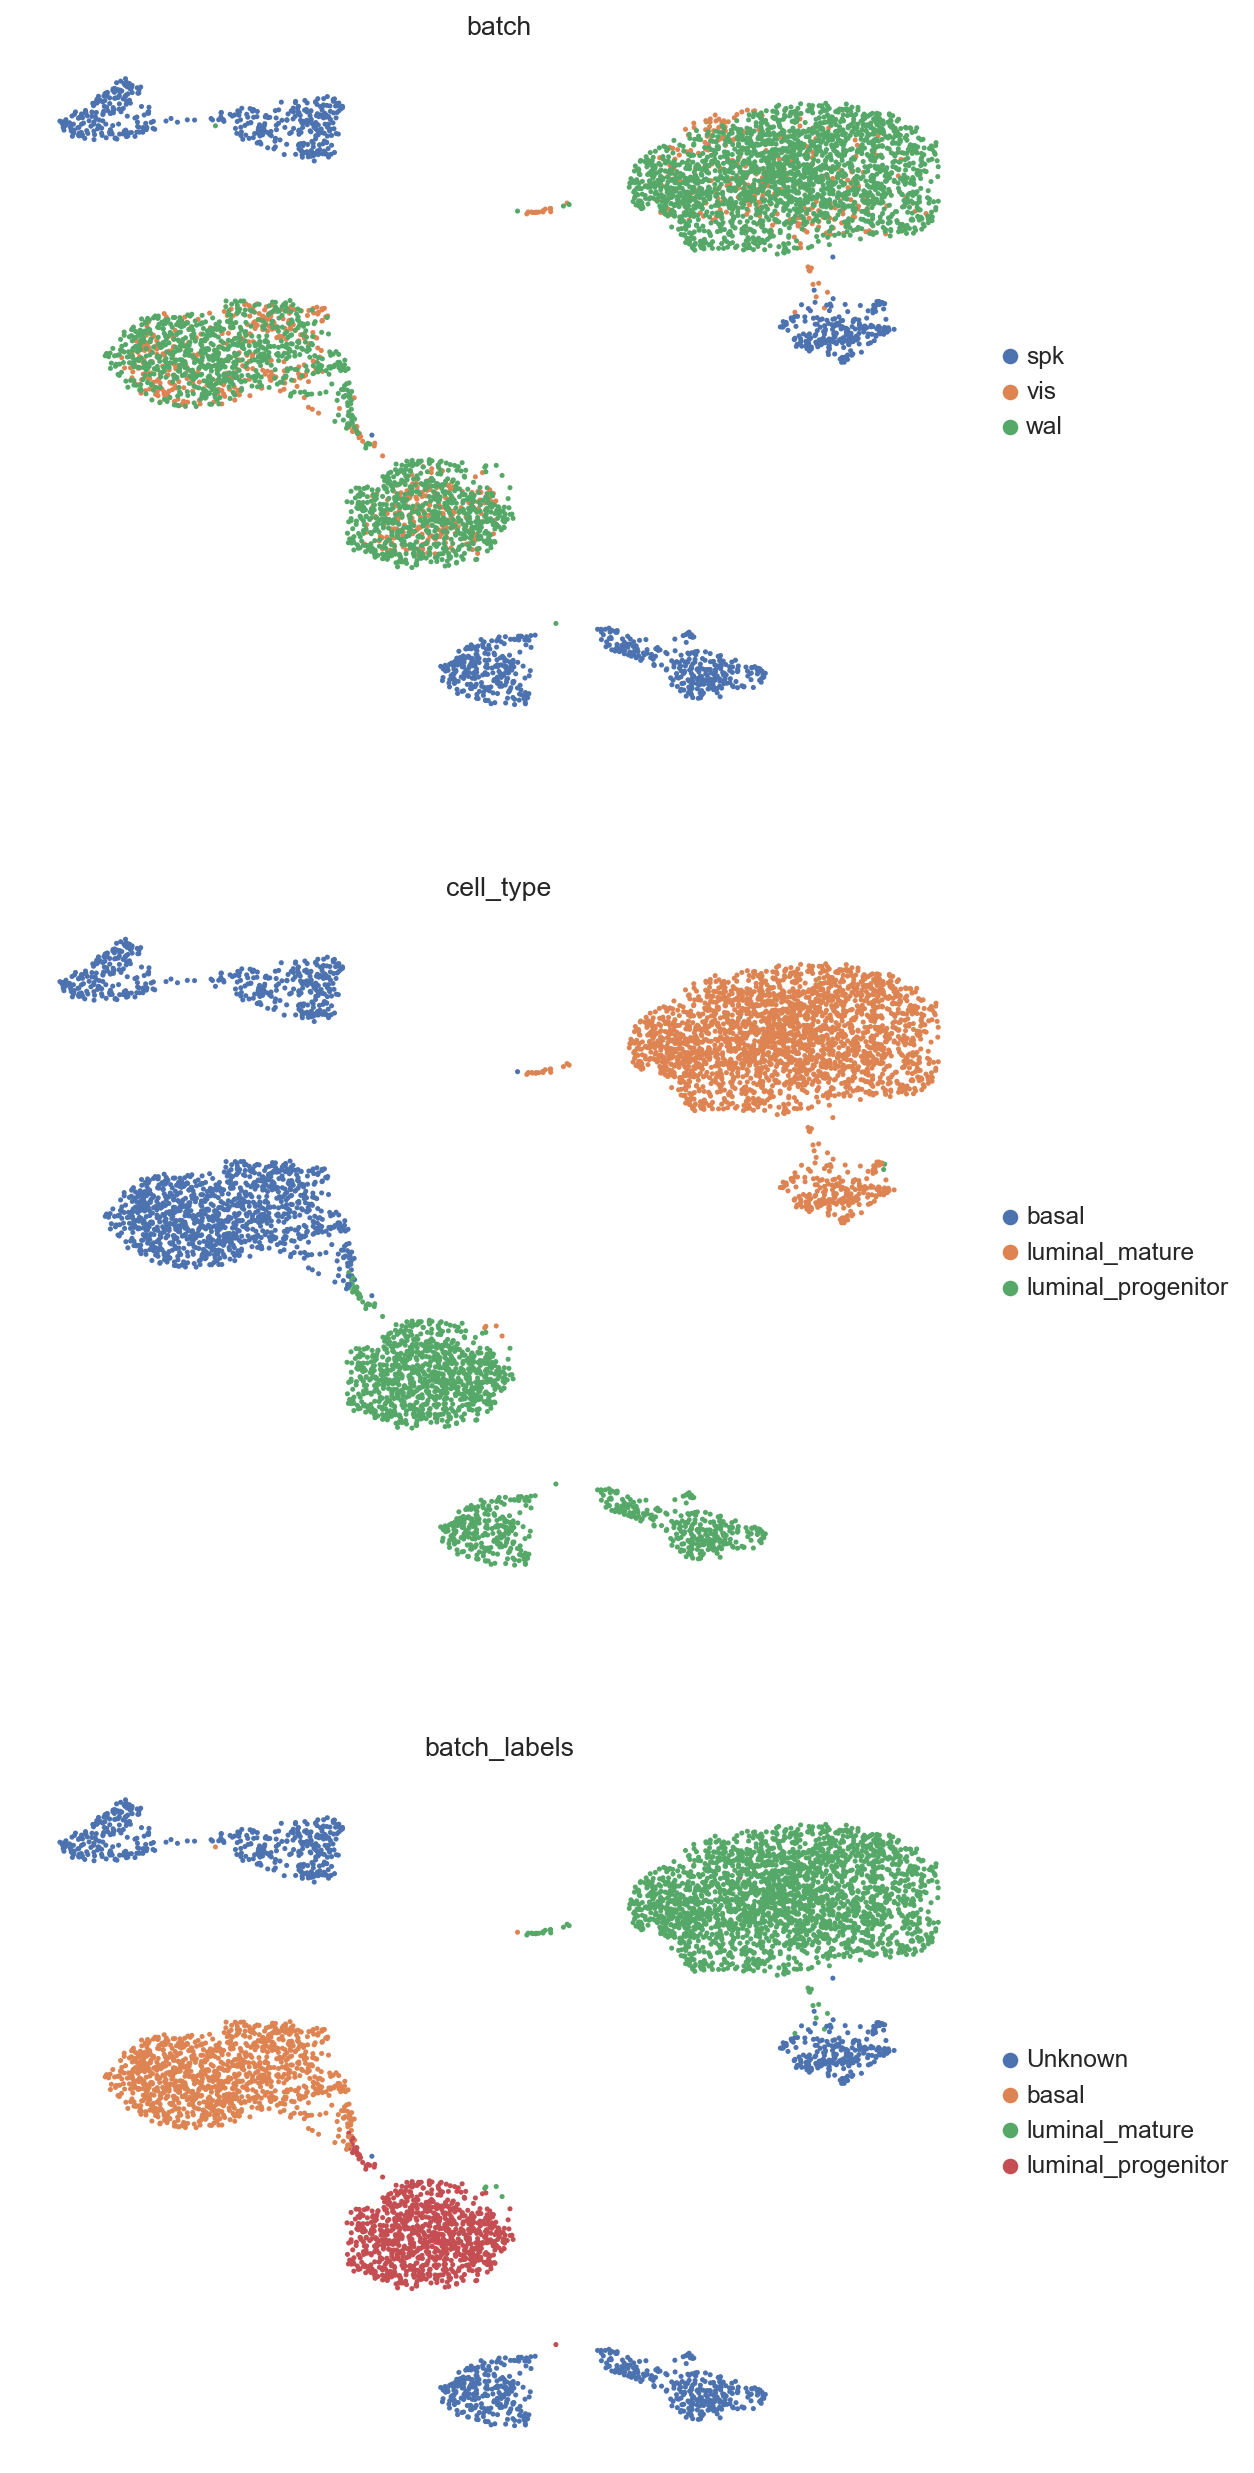

In [29]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'batch_labels'], wspace=0.4, frameon=False, ncols=1)

Seems that scGEN will treat the whole un-annotated batch as a new cell type and do no integration on it.

# STACAS

In [ ]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'batch_labels'], wspace=0.4, frameon=False, ncols=1)

Semi-supervised integration results

stacas will behave in unsupervised mode when cell type annotations are available for only one of the batches, so we skip this method for this setting.

In [ ]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/bct_stacas_embeddings_partially_annotated_batches_0.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scDREAMER

In [31]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/bct_partially_annotated_scdreamer_embeddings_1.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [32]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

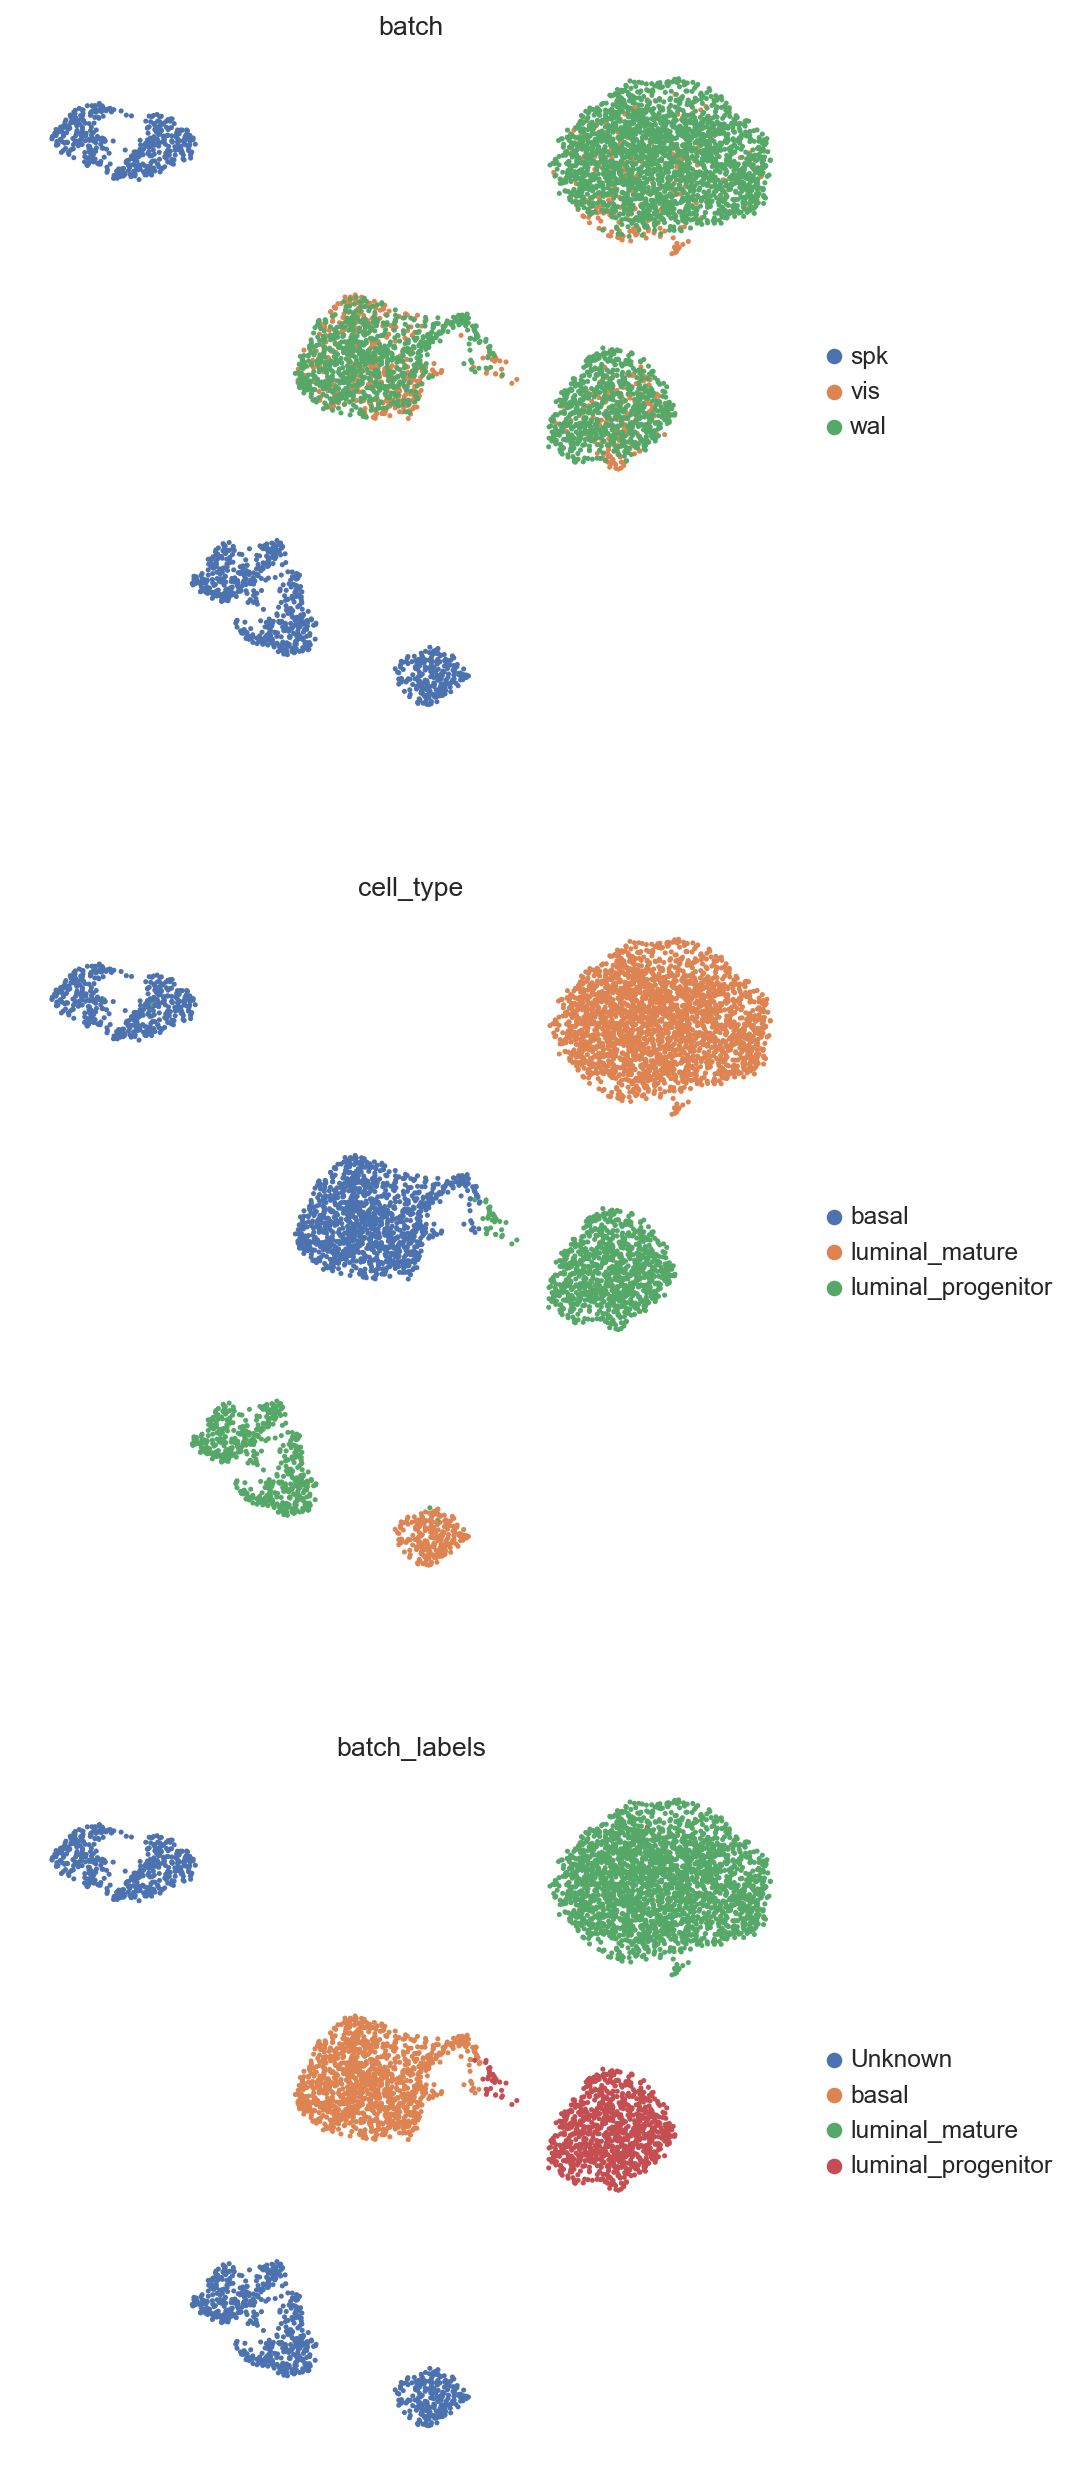

In [33]:
sc.pl.umap(adata, color=["batch", "cell_type", "batch_labels"], frameon=False, ncols=1)

# ItClust

In [37]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/partially_annotated_itclust_embeddings_bct_1.csv', index_col=0)

In [40]:
pca_embeddings = pca_embeddings[pca_embeddings.index.isin(adata.obs_names)]

In [41]:
adata.obsm['X_itclust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_itclust")
sc.tl.umap(adata, min_dist=0.5)

In [42]:
# Collect embeddings
embeddings_dict["X_itclust"] = pca_embeddings.values

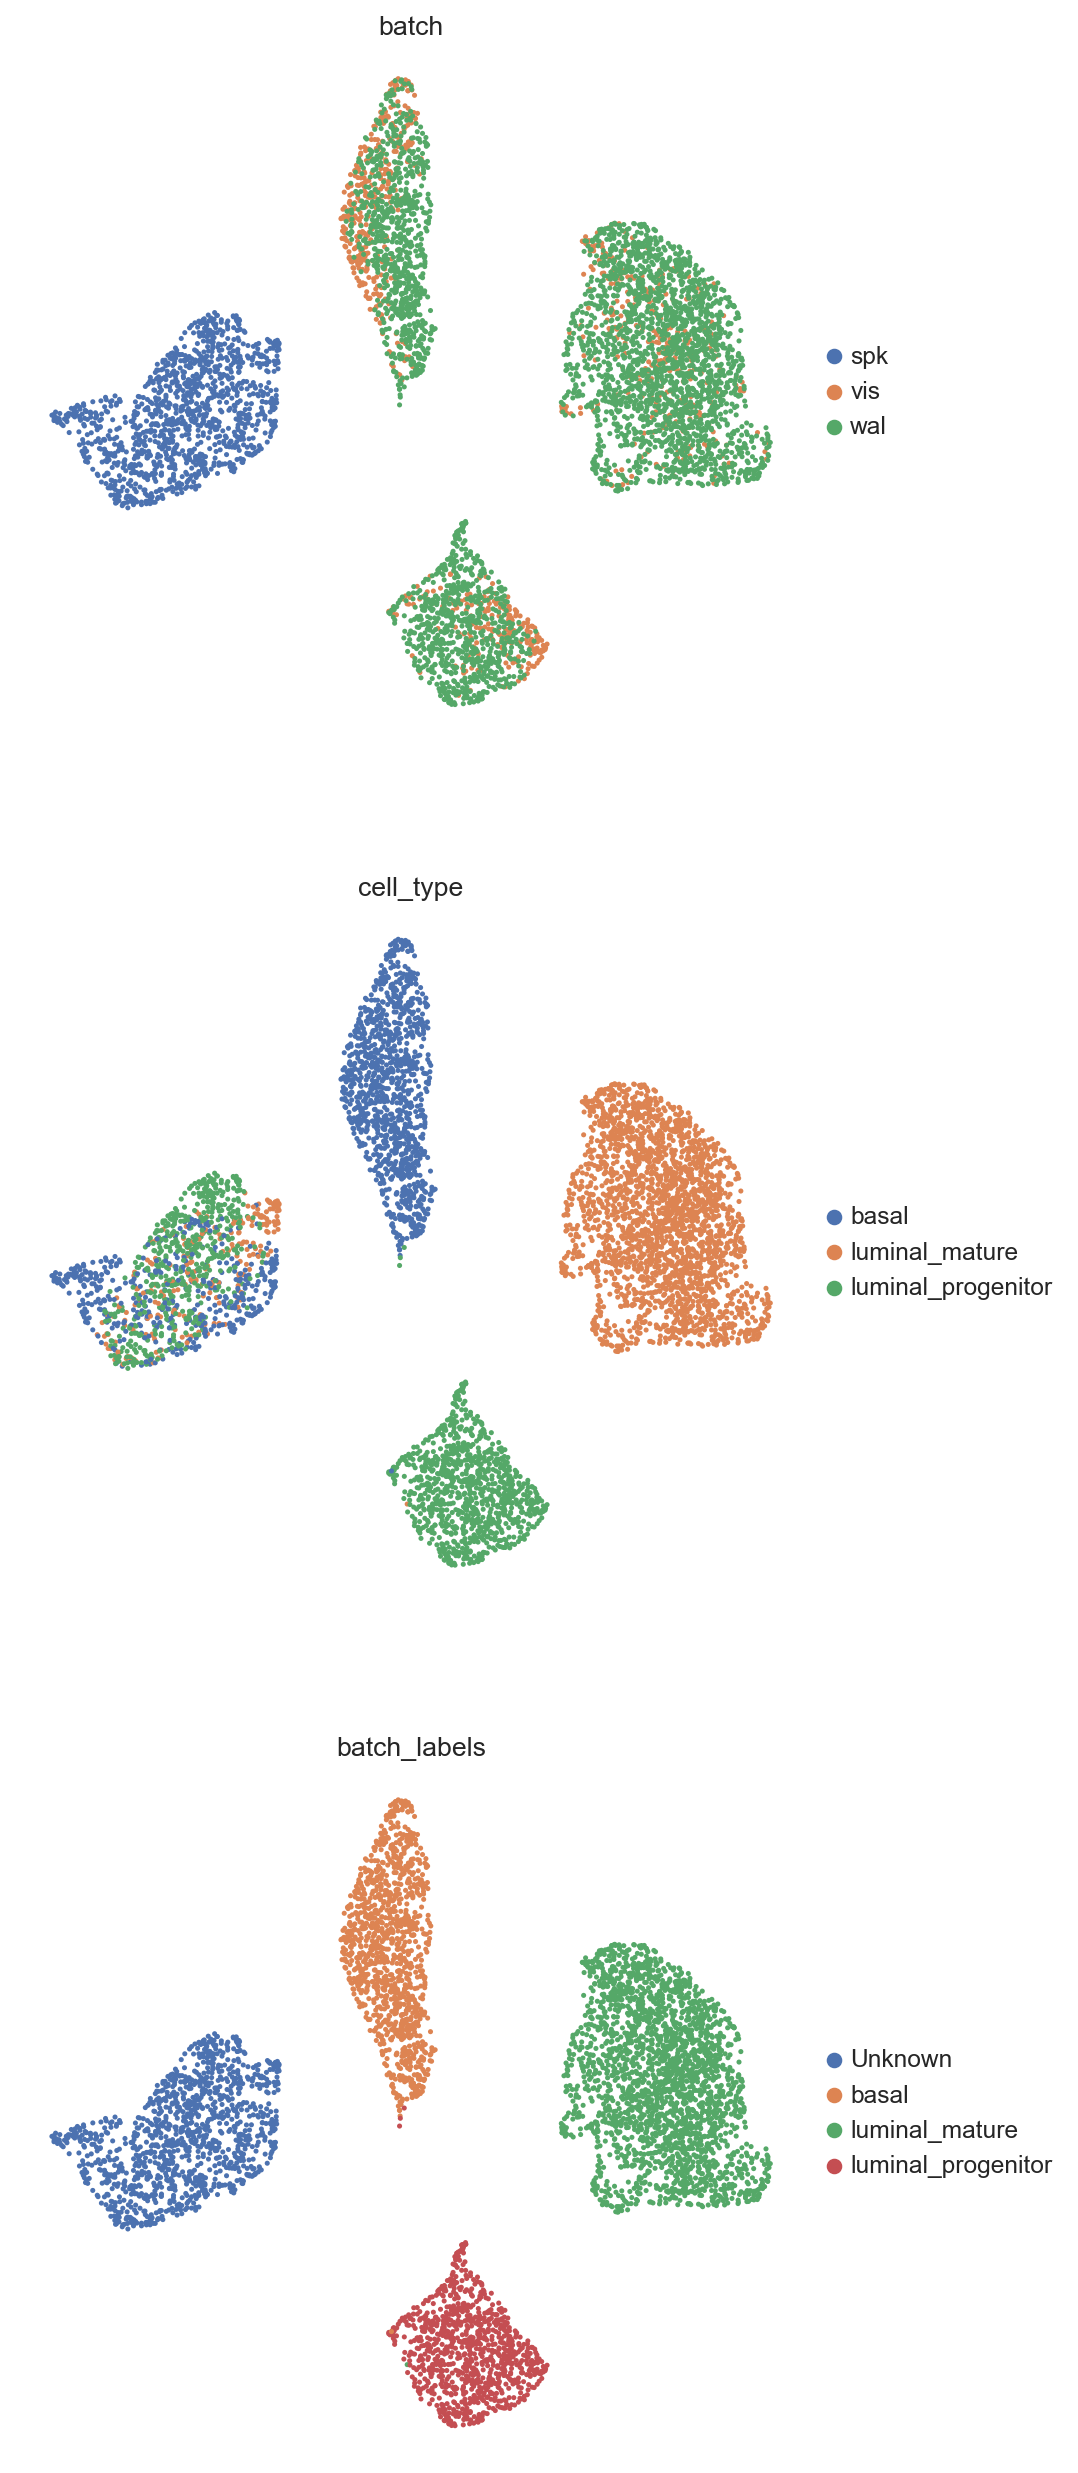

In [43]:
sc.pl.umap(adata, color=["batch", "cell_type", "batch_labels"], frameon=False, ncols=1)

In [45]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_bct_1.csv")


# Metric Evaluation

## read the embeddings

In [90]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/partially_annotated_batches_bct_0.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [93]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.8261369830069897
resolution: 0.2, nmi: 0.8290315299497211
resolution: 0.3, nmi: 0.8170933489215357
resolution: 0.4, nmi: 0.7950065212038899
resolution: 0.5, nmi: 0.7946020406013983
resolution: 0.6, nmi: 0.7981820935608092
resolution: 0.7, nmi: 0.7840318655645632
resolution: 0.8, nmi: 0.7837001229004236
resolution: 0.9, nmi: 0.7851048801514052
resolution: 1.0, nmi: 0.774770463013774
resolution: 1.1, nmi: 0.7754872283454797
resolution: 1.2, nmi: 0.7611965983306744
resolution: 1.3, nmi: 0.751702233310887
resolution: 1.4, nmi: 0.7500018010197382
resolution: 1.5, nmi: 0.746204504029705
resolution: 1.6, nmi: 0.7420345817153079
resolution: 1.7, nmi: 0.7415344400556816
resolution: 1.8, nmi: 0.7414673832417533
resolution: 1.9, nmi: 0.7371709399901959
resolution: 2.0, nmi: 0.7402477305781672
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8290315299497211


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scANVI


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [94]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7296844916384085
resolution: 0.2, nmi: 0.7323313152680218
resolution: 0.3, nmi: 0.7401739806609965
resolution: 0.4, nmi: 0.7557072718332029
resolution: 0.5, nmi: 0.7623655432946208
resolution: 0.6, nmi: 0.7627447468103815
resolution: 0.7, nmi: 0.760573982948117
resolution: 0.8, nmi: 0.7589487988205005
resolution: 0.9, nmi: 0.7622985979206773
resolution: 1.0, nmi: 0.7601127828569751
resolution: 1.1, nmi: 0.7541506458188657
resolution: 1.2, nmi: 0.7487963402955542
resolution: 1.3, nmi: 0.7424751662533663
resolution: 1.4, nmi: 0.7447868424320683
resolution: 1.5, nmi: 0.7472456390063441
resolution: 1.6, nmi: 0.745426963532636
resolution: 1.7, nmi: 0.7425367845817061
resolution: 1.8, nmi: 0.7389743345466894
resolution: 1.9, nmi: 0.7375202549581862
resolution: 2.0, nmi: 0.7414838676082423
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.7627447468103815


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [95]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.7693150728778826
resolution: 0.2, nmi: 0.7656363848027344
resolution: 0.3, nmi: 0.7854875468479927
resolution: 0.4, nmi: 0.7676734066506045
resolution: 0.5, nmi: 0.7591629218422818
resolution: 0.6, nmi: 0.7507333725184387
resolution: 0.7, nmi: 0.7492332939509803
resolution: 0.8, nmi: 0.7420193303416407
resolution: 0.9, nmi: 0.7433254829755739
resolution: 1.0, nmi: 0.7450957934895195
resolution: 1.1, nmi: 0.7443995252636255
resolution: 1.2, nmi: 0.7448299813009411
resolution: 1.3, nmi: 0.7427674708802677
resolution: 1.4, nmi: 0.7414253675475435
resolution: 1.5, nmi: 0.7400432384376263
resolution: 1.6, nmi: 0.7360520418770956
resolution: 1.7, nmi: 0.7382555575188238
resolution: 1.8, nmi: 0.7381401450272647
resolution: 1.9, nmi: 0.7345836024673085
resolution: 2.0, nmi: 0.7381580113677144
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.7854875468479927


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [96]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.837730,0.764959,0.786591
ARI_cluster/label,0.723264,0.534387,0.546318
ASW_label,0.604865,0.568876,0.614299
ASW_label/batch,0.810175,0.645468,0.759977
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.875633,0.778971,0.824298
isolated_label_silhouette,0.612201,0.567565,0.619870
graph_conn,0.989525,0.887266,0.984798
kBET,NaN,NaN,NaN


In [97]:
merged_df.to_csv("../metrics/bct_metrics_partially_annotated_0.csv", index=True)

In [98]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.837730,0.764959,0.786591
ARI_cluster/label,0.723264,0.534387,0.546318
ASW_label,0.604865,0.568876,0.614299
ASW_label/batch,0.810175,0.645468,0.759977
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.875633,0.778971,0.824298
isolated_label_silhouette,0.612201,0.567565,0.619870
graph_conn,0.989525,0.887266,0.984798
kBET,NaN,NaN,NaN
